In [584]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [585]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [586]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, dropout_rate=0.5):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.dZ = 0
        self.dA = 0
        self.dropout_rate = dropout_rate
        self.mask = None
        self.input_X_forward = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        dW = np.dot(self.input_X_forward.T, dA)
        dZ = np.dot(dA, self.W.T)
        self.dA = dA
        self.dW = dW
        self.dZ = dZ
        # 更新
        self = self.optimizer.update(self)
        return dZ
    
    def dropout_forward(self, X, flag):
        if flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask
        else:
            return X * (1.0 - self.dropout_rate)
        
    def dropout_backward(self, X): 
        return X * self.mask

In [633]:
class FC2:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer, dropout_rate=0.5):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.W_feedback = 0
        self.B_feedback = 0
        self.dZ = 0
        self.dA = 0
        self.dropout_rate = dropout_rate
        self.mask = None
        self.input_X_forward = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = np.dot(X, self.W) + self.B
        
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        #print("input_X_forward.shape:",self.input_X_forward.shape)
        #print("dA.shape:",dA.shape)
        #print("self X_forward:",self.input_X_forward.shape)
        #print("dA:",dA.shape)
        dW = np.dot(self.input_X_forward.T, dA)
        #print("dW:",dW.shape)
        dZ = np.dot(dA, self.W.T)
        self.dA = dA
        self.dW = dW
        self.dZ = dZ
        
        self.W_feedback = self.dW / self.dA.shape[0]
        self.B_feedback = np.average(self.dA, axis=0)
        
        # 更新
        #print("W.shape:",self.W.shape)
        self = self.optimizer.update(self)
        return dZ
    
    def dropout_forward(self, X, flag):
        if flag:
            self.mask = np.random.rand(*X.shape) > self.dropout_rate
            return X * self.mask
        else:
            return X * (1.0 - self.dropout_rate)
        
    def dropout_backward(self, X): 
        return X * self.mask

In [587]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma = 0.01):
        self.sigma = sigma
        
    def W(self, n_nodes1, n_nodes2):
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [588]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        layer.B = layer.B - self.lr * layer.B_feedback    
        layer.W = layer.W - self.lr * layer.W_feedback
        
        return layer

In [589]:
class Sigmoid:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return 1 / (1 + np.exp(-1 * X))
    
    def _func_diff(self, X):
        return (1 - self._func(X)) * self._func(X)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [590]:
class Tanh:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.tanh(X)
    
    def _func_diff(self, X):
        return 1 - (self._func(X))**2
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [936]:
class softmax:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
        self.pred = 0
    
    def _func(self, X):
        #X = X - np.max(X)
        #tmp = np.exp(X)
        #denominator = np.sum(tmp, axis=1)
        #output = tmp / denominator[:, np.newaxis]
        tmp = X - np.max(X)
        output = np.exp(tmp) / np.sum(np.exp(tmp))
        
        return output
    
    def _func_diff(self, X):
        return X
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        
        self.input_X_forward = X
        A = self._func(X)
        self.pred = A
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dZ = self.pred - dA
        
        return dZ

In [790]:
class ReLU:
    """
    活性化関数 : Sigmoid
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self):
        # 初期化
        self.input_X_forward = 0
    
    def _func(self, X):
        return np.maximum(0, X)
    
    def _func_diff(self, X):
        return np.where( X > 0, 1, 0)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """ 
        self.input_X_forward = X
        A = self._func(X)
        return A
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        
        grad = self._func_diff(self.input_X_forward)
        dZ = grad * dA
        return dZ

In [791]:
class XavierInitializer:
    """
    Xavierによる初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) / np.sqrt(n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) / np.sqrt(self.n_prev_nodes)
        return B

In [792]:
class HeInitializer:
    """
    Heによる初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self):
        self.n_prev_nodes = 1
        pass
        
    def W(self, n_nodes1, n_nodes2):
        self.n_prev_nodes = n_nodes1
        W = np.random.randn(n_nodes1, n_nodes2) * np.sqrt(2 / n_nodes1)
        return W
    
    def B(self, n_nodes2):
        B = np.random.randn(1, n_nodes2) * np.sqrt(2 / self.n_prev_nodes)
        return B

In [793]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
        self.H_B = 1
        self.H_W = 1
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        
        #dA, dWを更新＆保存
        self.H_B = self.H_B + np.average(layer.dA)**2
        self.H_W = self.H_W + np.average(layer.dW)**2
        
        layer.B = layer.B - self.lr * np.average(layer.dA, axis=0) / np.sqrt(self.H_B)
        layer.W = layer.W - self.lr * layer.dW / layer.dA.shape[0] / np.sqrt(self.H_W)
        
        return layer

###### 【問題1】2次元畳み込み層の作成
Sprint12で作成した1次元畳み込み層を発展させ、2次元畳み込み層のクラスConv2dを作成してください。

In [928]:
class Conv2d():
    """
    2次元Convolution層
    Parameters
    ----------
    n_input_hight : 入力２次元データの高さ
    n_input_width : 入力２次元データの幅
    f_w : フィルタ
    f_b :　バイアス
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_input_hight, n_input_width, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.n_input_hight = n_input_hight
        self.n_input_width = n_input_width
        self.W = f_w    #(n_output, n_ch, f_size_h, f_size_w)
        self.B = f_b    #(1, n_ch, n_output)
        self.n_output = self.W.shape[0]
        self.n_input_ch = self.W.shape[1]
        self.f_hight = f_w.shape[2]
        self.f_width = f_w.shape[3]
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.n_output_width = self.n_input_width - self.f_width + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_ch, n_feature11, n_feature12)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_output, n_feature21, n_feature22)
            出力
        """ 
        
        self.input_X_forward = X
        batch_size = self.input_X_forward.shape[0]
        A = np.zeros((batch_size, self.n_output, self.n_input_ch, self.n_output_hight, self.n_output_width))
        B = self.B[0]
        B = B.T
        B = B[np.newaxis]
        #batch方向の並列計算のためaxisを追加 (Batch, ch, hight, width) = > (batch, 1, ch, hight, width)
        X = X[:,np.newaxis]
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight
            for w in range(self.n_output_width):
                w1 = w
                w2 = w + self.f_width
                X_seg = X[:,:,:,h1:h2,w1:w2]

                #print("X:{} W:{}\n".format(X_seg.shape, self.W.shape))
                #アダマール積 (batch, 1, ch, filter_size) * (n_output, ch, filter_size)
                tmp = np.sum(np.sum(X_seg * self.W, axis=4), axis=3)
                tmp = tmp + B
                A[:,:,:,h,w] = tmp

        output = np.sum(A, axis=2)
        return output
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_output, n_feature21, n_feature22)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_ch, n_feature11, n_feature12)
            前に流す勾配
        """
        
        batch_size = self.input_X_forward.shape[0]
        
        #Wについて
        #X.shape (batch_size, n_input * n_output, n_feature11, n_feature12)
        X = np.tile(self.input_X_forward, (dA.shape[1] ,1 ,1))
        #dL.shape (n_input * n_output, n_featue2 )
        dL = np.zeros((batch_size, X.shape[1], dA.shape[2], dA.shape[3]))
        for i in range(self.n_output):
            o1 = i * self.n_input_ch
            o2 = i * self.n_input_ch + self.n_input_ch
            tmp = dA[:,i][:,np.newaxis]
            dL[:,o1:o2] = np.tile(tmp, (self.n_input_ch,1 ,1))
        
        #print("dL:",dL)
        #入力の特徴量数 - 出力の特徴量数 +1
        loop1 = self.n_input_hight - self.n_output_hight + 1
        loop2 = self.n_input_width - self.n_output_width + 1
        dW_tmp = np.zeros((batch_size, X.shape[1], loop1, loop2))
        for h in range(loop1):
            h1 = h
            h2 = h + self.n_output_hight
            for w in range(loop2):
                w1 = w
                w2 = w + self.n_output_width
                dX_seg = X[:,:, h1:h2, w1:w2]
                dW_tmp[:,:,h,w] = np.sum(np.sum(dL * dX_seg, axis=3), axis=2)
        
        #bacth方向の平均をとる
        dW_tmp2 = np.average(dW_tmp, axis=0)     
        #計算結果をフィルタサイズに整形
        for i in range(self.n_output):
            o1 = i * self.n_input_ch
            o2 = i * self.n_input_ch + self.n_input_ch
            self.W_feedback[i] = dW_tmp2[o1:o2]

        #Bについて
        #(batch_size, n_output, n_feature21, n_feature22)
        dB = np.sum(np.sum(dA, axis=3), axis=2)
        dB = np.average(dB, axis=0) #bacth方向の平均をとる
        for i in range(self.n_input_ch):
            self.B_feedback[:,i] = dB
        
        #Zについて Output数回す
        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(self.n_output):
            #損失(行列)の端の処理のため、列の前後に0列を追加（フィルタサイズから計算）
            dA_tmp = dA[:,i][:,np.newaxis,:]
            dA_padding = np.zeros([batch_size, 1, self.f_hight-1, dA_tmp.shape[3]])
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=2)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=2) 
            
            dA_padding = np.zeros([batch_size, 1, dA_tmp.shape[2], self.f_width-1])
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=3)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=3) 
            dA_tmp = np.tile(dA_tmp, (self.n_input_ch ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                for w in range(self.n_input_width):
                    w1 = w
                    w2 = w + self.f_width
                    
                    dA_seg = dA_tmp[:,:,h1:h2, w1:w2]
                    #並列計算工夫
                    dA_seg = np.fliplr(np.fliplr(dA_seg).T).T
                    #dA_seg = dA_seg[:,np.newaxis]
                    tmp = np.sum(np.sum(dA_seg * self.W[i], axis=3), axis=2)
                    #print("tmp.shape:",tmp.shape)
                    #print("dZ.shape:",dZ_seg.shape)
                    dZ_seg[:,:,h,w] = tmp
                
            self.Z_feedback += dZ_seg #出力数分足し算

        # 更新
        self = self.optimizer.update(self)
        return self.Z_feedback

In [929]:
#初期化、更新インスタンスを作る
optimizer = SGD(0.01)
initializer = XavierInitializer()

In [930]:
w = np.ones([2,2,2,2])
b = np.ones([1,2,2])
A = np.random.randint(0,10,(1,2,6,8))

In [931]:
Cov = Conv2d(6,8,w,b,initializer,optimizer)

In [932]:
dA = Cov.forward(A)

In [933]:
A

array([[[[8, 4, 5, 3, 4, 2, 2, 7],
         [9, 5, 2, 1, 4, 4, 1, 8],
         [9, 2, 5, 8, 2, 9, 4, 9],
         [6, 1, 2, 6, 2, 0, 0, 6],
         [9, 6, 2, 3, 2, 0, 9, 6],
         [1, 4, 4, 2, 5, 2, 3, 2]],

        [[3, 8, 2, 4, 7, 3, 3, 3],
         [6, 2, 5, 8, 7, 3, 3, 7],
         [2, 2, 0, 7, 0, 9, 5, 4],
         [8, 6, 4, 1, 6, 5, 8, 7],
         [4, 2, 2, 9, 0, 1, 4, 9],
         [4, 3, 0, 5, 8, 8, 7, 2]]]])

In [934]:
dA

array([[[[47., 35., 32., 40., 36., 23., 36.],
         [39., 25., 38., 39., 40., 40., 43.],
         [38., 24., 35., 34., 35., 42., 45.],
         [44., 27., 31., 31., 18., 29., 51.],
         [35., 25., 29., 36., 28., 36., 44.]],

        [[47., 35., 32., 40., 36., 23., 36.],
         [39., 25., 38., 39., 40., 40., 43.],
         [38., 24., 35., 34., 35., 42., 45.],
         [44., 27., 31., 31., 18., 29., 51.],
         [35., 25., 29., 36., 28., 36., 44.]]]])

In [935]:
Cov.backward(dA)

array([[[[ 94, 164, 134, 144, 152, 118, 118,  72],
         [172, 292, 260, 298, 310, 278, 284, 158],
         [154, 252, 244, 292, 296, 314, 340, 176],
         [164, 266, 234, 262, 236, 248, 334, 192],
         [158, 262, 224, 254, 226, 222, 320, 190],
         [ 70, 120, 108, 130, 128, 128, 160,  88]],

        [[ 94, 164, 134, 144, 152, 118, 118,  72],
         [172, 292, 260, 298, 310, 278, 284, 158],
         [154, 252, 244, 292, 296, 314, 340, 176],
         [164, 266, 234, 262, 236, 248, 334, 192],
         [158, 262, 224, 254, 226, 222, 320, 190],
         [ 70, 120, 108, 130, 128, 128, 160,  88]]]])

###### 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

In [1]:
def cal_output_data_size(input_X, filter_W, padding_size_h, padding_size_w, stride_h, stride_w):
    input_x_hight = input_X.shape[1]
    input_x_width = input_X.shape[2]
    output_ch = filter_W[0]
    filter_w_hight = filter_W.shape[3]
    filter_w_width = filter_W.shape[4]
    
    out_h = (input_x_hight + padding_size_h * 2 - filter_W_hight) / stride_h + 1
    out_w = (input_x_width + padding_size_w * 2 - filter_W_width) / stride_w + 1
    
    return out_ch, out_h, out_w

###### 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。プーリング層は数式で表さない方が分かりやすい部分もありますが、フォワードプロパゲーションの数式は以下のようになります。

In [571]:
class Max_pooling():
    
    def __init__(self, stride_h, stride_w):
        self.h = stride_h
        self.w = stride_w
        self.max_pos = 0
        self.backward_map = 0
        
    def forward(self, X):
        """
        X.shape (batch_size, ch, h, w)
        """
        batch_size = X.shape[0]
        ch_size = X.shape[1]
        h_size = X.shape[2]
        w_size = X.shape[3]
        
        output_size_h = (int)(h_size / self.h) 
        output_size_w = (int)(w_size / self.w)
        output = np.zeros((batch_size, ch_size, output_size_h, output_size_w))
        self.backward_map = np.zeros((batch_size, ch_size, output_size_h, output_size_w, self.h, self.w))
        
        #print("input:\n",X)
        for n_h in range(output_size_h):
            for n_w in range(output_size_w):
                pos_h1 = n_h + n_h * (self.h - 1)
                pos_h2 = pos_h1 + self.h
                pos_w1 = n_w + n_w * (self.w - 1)
                pos_w2 = pos_w1 + self.w

                tmp = np.max(np.max(X[:,:, pos_h1:pos_h2, pos_w1:pos_w2], axis=3), axis=2)
                #tmp = np.max(tmp, axis=2)
                output[:,:, n_h, n_w] = tmp
                tmp = tmp[:,:,np.newaxis,np.newaxis]
                self.backward_map[:,:, n_h, n_w] = (X[:,:, pos_h1:pos_h2, pos_w1:pos_w2] == tmp)
                
        #print("T/F:",self.backward_map)
        self.backward_map = self.backward_map.astype(int)
        
        return output
        
    def backward(self, dA):
        """
        dA.shape (batch_size, ch, h, w)
        """        
        batch_size = dA.shape[0]
        ch_size = dA.shape[1]
        h_size = dA.shape[2]
        w_size = dA.shape[3]
        
        output_size_h = h_size * self.h
        output_size_w = w_size * self.w
        output = np.zeros((batch_size, ch_size, output_size_h, output_size_w))
        for n_h in range(h_size):
            for n_w in range(w_size):
                pos_h1 = n_h + n_h * (self.h - 1)
                pos_h2 = pos_h1 + self.h
                pos_w1 = n_w + n_w * (self.w - 1)
                pos_w2 = pos_w1 + self.w                    

                #print("dA:\n", dA[:,:, n_h, n_w])
                #print("back:\n", self.backward_map[:,:, n_h, n_w])                    
                tmp = dA[:,:, n_h, n_w][:,:, np.newaxis, np.newaxis]
                output[:,:, pos_h1:pos_h2, pos_w1:pos_w2] = tmp * self.backward_map[:,:, n_h, n_w]

        return output

In [572]:
p = Max_pooling(2,2)

In [573]:
A = np.random.randint(0,10,(1,3,6,8))

In [574]:
dA = p.forward(A)

In [575]:
print("input:\n",A)
print("output:\n",dA)

input:
 [[[[2 7 8 8 0 5 3 5]
   [3 8 4 8 2 6 1 1]
   [3 6 1 1 2 3 3 4]
   [3 2 1 6 7 6 7 9]
   [6 1 6 0 9 3 7 8]
   [8 4 6 6 6 3 6 0]]

  [[5 7 5 8 9 0 9 6]
   [5 9 0 4 9 0 3 0]
   [0 6 4 9 3 6 3 5]
   [8 1 9 1 3 3 2 8]
   [3 6 7 5 4 6 9 4]
   [6 1 4 1 2 3 7 9]]

  [[6 0 5 4 7 1 0 5]
   [7 5 8 3 7 0 2 0]
   [1 2 4 2 2 3 9 2]
   [3 0 1 1 5 6 3 4]
   [6 8 3 4 5 0 8 9]
   [1 3 2 0 9 4 8 9]]]]
output:
 [[[[8. 8. 6. 5.]
   [6. 6. 7. 9.]
   [8. 6. 9. 8.]]

  [[9. 8. 9. 9.]
   [8. 9. 6. 8.]
   [6. 7. 6. 9.]]

  [[7. 8. 7. 5.]
   [3. 4. 6. 9.]
   [8. 4. 9. 9.]]]]


In [576]:
p.backward(dA)

array([[[[0., 0., 8., 8., 0., 0., 0., 5.],
         [0., 8., 0., 8., 0., 6., 0., 0.],
         [0., 6., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 6., 7., 0., 0., 9.],
         [0., 0., 6., 0., 9., 0., 0., 8.],
         [8., 0., 6., 6., 0., 0., 0., 0.]],

        [[0., 0., 0., 8., 9., 0., 9., 0.],
         [0., 9., 0., 0., 9., 0., 0., 0.],
         [0., 0., 0., 9., 0., 6., 0., 0.],
         [8., 0., 9., 0., 0., 0., 0., 8.],
         [0., 6., 7., 0., 0., 6., 9., 0.],
         [6., 0., 0., 0., 0., 0., 0., 9.]],

        [[0., 0., 0., 0., 7., 0., 0., 5.],
         [7., 0., 8., 0., 7., 0., 0., 0.],
         [0., 0., 4., 0., 0., 0., 9., 0.],
         [3., 0., 0., 0., 0., 6., 0., 0.],
         [0., 8., 0., 4., 0., 0., 0., 9.],
         [0., 0., 0., 0., 9., 0., 0., 9.]]]])

###### 【問題4】平滑化
平滑化するためのクラスFlatten()を作成してください。
フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。

In [784]:
class Flatten2():
    
    def __init__(self):
        self.input_X_shape = 0
        
    def forward(self, X):
        """
        X.shape (batch_size, n_output, n_feature1, n_feature2)
        
        return (batch_size, n_output * n_feature1 * n_feature2)
        """
        self.inout_X_shape = X.shape
        #print("Flatten input x shape:",X.shape)
        output = X.reshape([self.inout_X_shape[0], self.inout_X_shape[1] * self.inout_X_shape[2] * self.inout_X_shape[3]])
        return output
    
    def backward(self, X):
        output = X.reshape(self.inout_X_shape)
        return output

###### 【問題5】学習・推定
作成したConv2dを使用してMNISTの分類を学習・推定してください。
この段階では精度は気にせず、動くことを確認してください。

In [911]:
default_dnn_design = {
    'learning_rate':0.001,
    'total_layer':3,
    'func_layer1':'tanh',
    'func_layer2':'tanh',
    'func_layer3':'softmax',
    'node_layer0':786, 
    'node_layer1':400,
    'node_layer2':200,
    'node_layer3':10,
    'initializer':'SimpleInitializer',
    'initializer_sigma':0.05,
    'optimizer':'SGD',
}

class ScratchDeepNeuralNetrowkClassifier2():
    """
    ディープニューラルネットワーク分類器

    Parameters
    ----------

    Attributes
    ----------
    """
    
    def __init__(self, n_epoch, batch_size, verbose = False):
        self.verbose = verbose
        self.batch_size = batch_size
        self.n_epoch = n_epoch
        self.loss = 0
        self.loss_val = 0
        self.activation_func = 0
        self.affine_func = 0
        self.n_layer = 0
        self.layer_instance = [0 for _ in range(64)]
        #self.activation_func = [0 for _ in range(self.dnn_design.get('total_layer'))]
        #self.affine_func = [0 for _ in range(self.dnn_design.get('total_layer'))]
        #self.n_layer = self.dnn_design.get('total_layer')
        
        #各インスタンスを生成
        #initializerインスタンス
        
    def _crossentropy(self, y_pred, y):
        #クロスエントロピーを計算する
        INF_AVOIDANCE = 1e-8
        cross_entropy = -1 * y * np.log(y_pred + INF_AVOIDANCE)
        return np.sum(cross_entropy, axis=1)
    
    def add_layer(self, model):
        self.layer_instance[self.n_layer] = model
        self.n_layer += 1
        return
    
    def delet_all_layer(self):
        #add_layerでセットしたlayer情報を全てクリアする
        self.layer_instance[0:self.n_layer] = 0
        self.n_layer = 0
        
        return
    
    def fit(self, X, y, X_val=None, y_val=None):
        #lossの記録用の配列を用意
        self.loss = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        self.loss_val = [[0 for i in range(X.shape[0])] for j in range(self.n_epoch)]
        
        i = 0
        get_mini_batch = GetMiniBatch(x_train, y_train, self.batch_size)
        for epoch in range(self.n_epoch):
            #print("Proceeding Epoch:", i+1)
            loop_count = 0
            sum_loss = 0
            for mini_X_train, mini_y_train in get_mini_batch:
                X = mini_X_train
                #Forwardの計算
                for layer in range(self.n_layer):
                    #print("Cal forward layer:{}".format(layer))
                    #X = self.affine_func[layer].forward(X)
                    #X = self.activation_func[layer].forward(X)
                    X = self.layer_instance[layer].forward(X)
                    #print("layer:{} X:\n{}".format(layer, X))
                
                #Loss計算
                #print("X.shape:{} Y.shape:{}".format(X.shape, mini_y_train.shape))
                sum_loss += self._crossentropy(X, mini_y_train)
                    
                #Backwardの計算
                dz = mini_y_train
                for layer in reversed(range(0, self.n_layer)):
                    #print("Cal backward layer:{}".format(layer))
                    #dz = self.activation_func[layer].backward(dz)
                    #dz = self.affine_func[layer].backward(dz)
                    dz = self.layer_instance[layer].backward(dz)
                    #print("layer:{} dz:\n{}".format(layer, dz))
                
                loop_count += 1
                
            #Epoch毎のLoss計算結果表示
            self.loss[i] = sum_loss / loop_count
            if X_val is not None and y_val is not None:
                y_val_pred = self._predict(X_val)
                self.loss_val[i] = self._crossentropy(y_val_pred, y_val)
                
            if self.verbose:
                #verboseをTrueにした際は学習過程などを出力する
                print("Epoch:{} \n Loss:\n{} Loss(val):\n{}".format(i+1, self.loss[i], self.loss_val[i]))
                
            i +=1
            
        return
    
    def predict(self, X):
        #Forwardの計算
        for layer in range(self.n_layer):
            #X = self.affine_func[layer].forward(X)
            #X = self.activation_func[layer].forward(X)
            X = self.layer_instance[layer].forward(X)
        
        max_val = np.max(X, axis=1)
        mask = np.ones_like(X)
        X[X == max_val[:,np.newaxis]] = 1
        X[X != mask] = 0        
        
        return X

    def _predict(self, X):
        #Forwardの計算
        for layer in range(self.n_layer):
            #X = self.affine_func[layer].forward(X)
            #X = self.activation_func[layer].forward(X)  
            X = self.layer_instance[layer].forward(X)
        
        return X

In [912]:
class Conv2d():
    """
    2次元Convolution層
    Parameters
    ----------
    n_input_hight : 入力２次元データの高さ
    n_input_width : 入力２次元データの幅
    f_w : フィルタ
    f_b :　バイアス
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_input_hight, n_input_width, f_w, f_b, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.n_input_hight = n_input_hight
        self.n_input_width = n_input_width
        self.W = f_w    #(n_output, n_ch, f_size_h, f_size_w)
        self.B = f_b    #(1, n_ch, n_output)
        self.n_output = self.W.shape[0]
        self.n_input_ch = self.W.shape[1]
        self.f_hight = f_w.shape[2]
        self.f_width = f_w.shape[3]
        self.n_output_hight = self.n_input_hight - self.f_hight + 1
        self.n_output_width = self.n_input_width - self.f_width + 1
        self.input_X_forward = 0
        self.output_X_forward = np.zeros((self.W.shape[0], self.n_output_hight))
        self.W_feedback = np.zeros_like(self.W)
        self.B_feedback = np.zeros_like(self.B)
        self.Z_feedback = 0
    
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_ch, n_feature11, n_feature12)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_output, n_feature21, n_feature22)
            出力
        """ 
        
        self.input_X_forward = X
        batch_size = self.input_X_forward.shape[0]
        A = np.zeros((batch_size, self.n_output, self.n_input_ch, self.n_output_hight, self.n_output_width))
        B = self.B[0]
        B = B.T
        B = B[np.newaxis]
        #batch方向の並列計算のためaxisを追加 (Batch, ch, hight, width) = > (batch, 1, ch, hight, width)
        X = X[:,np.newaxis]
        for h in range(self.n_output_hight):
            h1 = h
            h2 = h + self.f_hight
            for w in range(self.n_output_width):
                w1 = w
                w2 = w + self.f_width
                X_seg = X[:,:,:,h1:h2,w1:w2]

                #print("X:{} W:{}\n".format(X_seg.shape, self.W.shape))
                #アダマール積 (batch, 1, ch, filter_size) * (n_output, ch, filter_size)
                tmp = np.sum(np.sum(X_seg * self.W, axis=4), axis=3)
                tmp = tmp + B
                A[:,:,:,h,w] = tmp

        output = np.sum(A, axis=2)
        return output
    
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_output, n_feature21, n_feature22)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_ch, n_feature11, n_feature12)
            前に流す勾配
        """
        
        batch_size = self.input_X_forward.shape[0]
        
        #Wについて
        #X.shape (batch_size, n_input * n_output, n_feature11, n_feature12)
        X = np.tile(self.input_X_forward, (dA.shape[1] ,1 ,1))
        #dL.shape (n_input * n_output, n_featue2 )
        dL = np.zeros((batch_size, X.shape[1], dA.shape[2], dA.shape[3]))
        for i in range(self.n_output):
            o1 = i * self.n_input_ch
            o2 = i * self.n_input_ch + self.n_input_ch
            tmp = dA[:,i][:,np.newaxis]
            dL[:,o1:o2] = np.tile(tmp, (self.n_input_ch,1 ,1))
        
        #print("dL:",dL)
        #入力の特徴量数 - 出力の特徴量数 +1
        loop1 = self.n_input_hight - self.n_output_hight + 1
        loop2 = self.n_input_width - self.n_output_width + 1
        dW_tmp = np.zeros((batch_size, X.shape[1], loop1, loop2))
        for h in range(loop1):
            h1 = h
            h2 = h + self.n_output_hight
            for w in range(loop2):
                w1 = w
                w2 = w + self.n_output_width
                dX_seg = X[:,:, h1:h2, w1:w2]
                dW_tmp[:,:,h,w] = np.sum(np.sum(dL * dX_seg, axis=3), axis=2)
        
        #bacth方向の平均をとる
        dW_tmp2 = np.average(dW_tmp, axis=0)     
        #計算結果をフィルタサイズに整形
        for i in range(self.n_output):
            o1 = i * self.n_input_ch
            o2 = i * self.n_input_ch + self.n_input_ch
            self.W_feedback[i] = dW_tmp2[o1:o2]

        #Bについて
        #(batch_size, n_output, n_feature21, n_feature22)
        dB = np.sum(np.sum(dA, axis=3), axis=2)
        dB = np.average(dB, axis=0) #bacth方向の平均をとる
        for i in range(self.n_input_ch):
            self.B_feedback[:,i] = dB
        
        #Zについて Output数回す
        self.Z_feedback = np.zeros_like(self.input_X_forward)
        for i in range(self.n_output):
            #損失(行列)の端の処理のため、列の前後に0列を追加（フィルタサイズから計算）
            dA_tmp = dA[:,i][:,np.newaxis,:]
            dA_padding = np.zeros([batch_size, 1, self.f_hight-1, dA_tmp.shape[3]])
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=2)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=2) 
            
            dA_padding = np.zeros([batch_size, 1, dA_tmp.shape[2], self.f_width-1])
            dA_tmp = np.concatenate((dA_tmp, dA_padding), axis=3)
            dA_tmp = np.concatenate((dA_padding, dA_tmp), axis=3) 
            dA_tmp = np.tile(dA_tmp, (self.n_input_ch ,1))
            dZ_seg = np.zeros_like(self.Z_feedback)
            
            for h in range(self.n_input_hight):
                h1 = h
                h2 = h + self.f_hight
                for w in range(self.n_input_width):
                    w1 = w
                    w2 = w + self.f_width
                    
                    dA_seg = dA_tmp[:,:,h1:h2, w1:w2]
                    #並列計算工夫
                    dA_seg = np.fliplr(np.fliplr(dA_seg).T).T
                    #dA_seg = dA_seg[:,np.newaxis]
                    tmp = np.sum(np.sum(dA_seg * self.W[i], axis=3), axis=2)
                    #print("tmp.shape:",tmp.shape)
                    #print("dZ.shape:",dZ_seg.shape)
                    dZ_seg[:,:,h,w] = tmp
                
            self.Z_feedback += dZ_seg #出力数分足し算

        # 更新
        self = self.optimizer.update(self)
        return self.Z_feedback

In [862]:
from keras.datasets import mnist
from sklearn.preprocessing import OneHotEncoder
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#x_train = x_train.reshape(-1, 784)
#x_test = x_test.reshape(-1, 784)

#0~255を0~1スケールへ
x_train = x_train.astype(np.float)
x_test = x_test.astype(np.float)
x_train /= 255
x_test /= 255

#0~9をone-hot encoding
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

#chを追加
x_train = x_train[:,np.newaxis,:]
x_test = x_test[:,np.newaxis,:]

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train_one_hot, test_size=0.95)
print(x_train.shape) # (48000, 784)
print(x_val.shape) # (12000, 784)

(3000, 1, 28, 28)
(57000, 1, 28, 28)


In [904]:
w = np.random.randn(2,1,2,2)
b = np.random.randn(1,1,2)
#A = np.random.randint(0,10,(1,2,6,8))

In [721]:
CNN2 = ScratchDeepNeuralNetrowkClassifier2(10, 10)

In [722]:
#DNNデザイン
CNN2.add_layer(Conv2d(x_train.shape[2],x_train.shape[3], w, b, initializer, optimizer))
CNN2.add_layer(Flatten2())
CNN2.add_layer(FC2(w.shape[0] * (x_train.shape[2] - w.shape[2] + 1) * (x_train.shape[3] - w.shape[3] + 1), 100, initializer, optimizer))
CNN2.add_layer(Sigmoid())
CNN2.add_layer(FC2(100, 10, initializer, optimizer))
CNN2.add_layer(softmax())

In [723]:
CNN2.fit(x_train, y_train, x_val, y_val)

In [724]:
y_pred = CNN2.predict(x_val)

In [729]:
print("Pred=\n", y_pred)
print("Yval=\n", y_val)

Pred=
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
Yval=
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [726]:
print("Accuracy score={:.3f}".format(accuracy_score(y_pred, y_val)))

Accuracy score=0.902


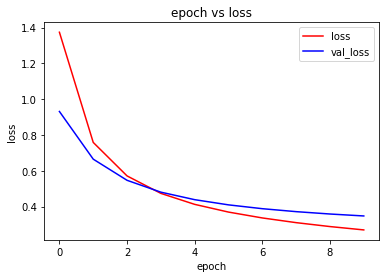

In [727]:
loss = np.array(CNN2.loss)
loss_ave = np.average(loss, axis=1)

loss_val = np.array(CNN2.loss_val)
loss_val_ave = np.average(loss_val, axis=1)

plt.title("epoch vs loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_ave, "r", label="loss")
plt.plot(loss_val_ave, "b", label="val_loss")
plt.legend()
#plt.yscale("Log")
plt.show()

###### 【問題6】（アドバンス課題）LeNet
CNNで画像認識を行う際は、フィルタサイズや層の数などを１から考えるのではなく、有名な構造を利用することが一般的です。
サブサンプリングとは現在のプーリングに相当するものです。現代風に以下のように作ってみることにします。活性化関数も当時はシグモイド関数ですが、ReLUとします。  

畳み込み層　出力チャンネル数6、フィルタサイズ5×5、ストライド1  
ReLU  
最大プーリング  
畳み込み層　出力チャンネル数16、フィルタサイズ5×5、ストライド1  
ReLU  
最大プーリング  
平滑化  
全結合層　出力ノード数120  
ReLU  
全結合層　出力ノード数84  
ReLU  
全結合層　出力ノード数10  
ソフトマックス関数  

In [913]:
n_epoch = 10
n_batch = 20

In [914]:
CNN3 = ScratchDeepNeuralNetrowkClassifier2(n_epoch, n_batch, verbose =True)

In [915]:
conv_w_lenet1 = np.random.randn(6,1,5,5)
conv_b_lenet1 = np.random.randn(1,1,6)

In [916]:
conv_w_lenet2 = np.random.randn(16,6,5,5)
conv_b_lenet2 = np.random.randn(1,6,16)

In [917]:
#DNNデザイン
CNN3.add_layer(Conv2d(x_train.shape[2],x_train.shape[3], conv_w_lenet1, conv_b_lenet1, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(ReLU())
CNN3.add_layer(Max_pooling(2,2))
CNN3.add_layer(Conv2d(12,12, conv_w_lenet2, conv_b_lenet2, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(ReLU())
CNN3.add_layer(Max_pooling(2,2))
CNN3.add_layer(Flatten2())
CNN3.add_layer(FC2(256, 120, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(ReLU())
CNN3.add_layer(FC2(120, 84, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(ReLU())
CNN3.add_layer(FC2(84, 10, SimpleInitializer(), SGD(0.01)))
CNN3.add_layer(softmax())

In [918]:
CNN3.fit(x_train, y_train, x_val, y_val)

Epoch:0 Loss:[2.08198785 2.07380429 2.09045099 2.07036911 2.04661384 2.01075812
 2.09455    2.12586225 2.06563038 2.03775421 2.10662619 2.08629494
 2.10500621 2.11393354 2.02277715 2.0890891  2.0590412  2.10968905
 2.12703713 2.05237148] Loss(val):[0.67308609 2.05978883 1.81099223 ... 2.29058466 2.55968798 0.70718972]
Epoch:1 Loss:[1.20350211 1.07499465 1.1760097  1.22035203 1.18857693 1.17927005
 1.29060517 1.27172893 1.29066286 1.25487038 1.12213232 1.13544966
 1.20962599 1.22375913 1.1478295  1.11679901 1.11192286 1.19455375
 1.23092222 1.21387682] Loss(val):[0.05075557 1.21704604 1.61724795 ... 1.50651849 1.09922481 0.06612355]
Epoch:2 Loss:[0.65310005 0.55238612 0.62755812 0.67174243 0.70782765 0.75983207
 0.68726609 0.7401475  0.77069295 0.77266132 0.65354079 0.59258109
 0.76109608 0.74973971 0.63907465 0.68218    0.67750449 0.71061851
 0.67376176 0.7325704 ] Loss(val):[0.00397843 1.14852163 1.85934415 ... 2.69091007 2.1029543  0.01141579]
Epoch:3 Loss:[0.45663694 0.33585494 0.41

In [815]:
x_val.shape

(57000, 1, 28, 28)

In [920]:
y_pred = CNN3.predict(x_val)

In [921]:
print("Accuracy score={:.3f}".format(accuracy_score(y_pred, y_val)))

Accuracy score=0.891


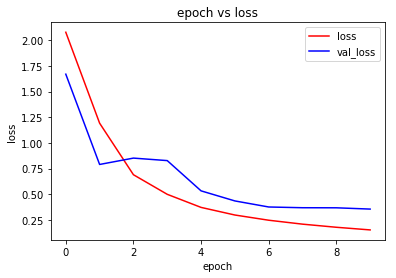

In [919]:
loss = np.array(CNN3.loss)
loss_ave = np.average(loss, axis=1)

loss_val = np.array(CNN3.loss_val)
loss_val_ave = np.average(loss_val, axis=1)

plt.title("epoch vs loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(loss_ave, "r", label="loss")
plt.plot(loss_val_ave, "b", label="val_loss")
plt.legend()
#plt.yscale("Log")
plt.show()

###### 【問題7】（アドバンス課題）有名な画像認識モデルの調査
CNNの代表的な構造としてははAlexNet(2012)、VGG16(2014)などがあります。こういったものはフレームワークで既に用意されていることも多いです。  
どういったものがあるか簡単に調べてまとめてください。名前だけでも見ておくと良いでしょう。

###### 1. AlexNet  
畳み込み層を5層重ねつつ，pooling層で特徴マップを縮小し，その後，3層の全結合層により最終的な出力を得る．基本的なアーキテクチャの設計思想はNeocognitronやLeNetを踏襲している  

###### 2. ZFNet  
AlexNetの最初の畳み込み層のフィルタサイズを11から7に縮小＆strideを4から2に縮小したモデル  

###### 3. ResNet  
処理ブロックへの入力xをショートカットし，H(x)=F(x)+xを次の層に渡す。  
勾配消失を緩和することができるためより深い層を作ることができる。

###### 4. GoogleNet
複数の畳み込み層やpooling層から構成されるInceptionモジュールと呼ばれる小さなネットワーク (micro networks) を定義し，これを通常の畳み込み層のように重ねていくことで1つの大きなCNNを作り上げる

###### 5. SENet
特徴マップをチャネル毎に適応的に重み付けするAttentionの機構を導入したネットワークである  

###### 【問題8】（アドバンス課題）平均プーリングの作成
平均プーリング層のクラスAveragePool2Dを作成してください。
範囲内の最大値ではなく、平均値を出力とするプーリング層です。
画像認識関係では最大プーリング層が一般的で、平均プーリングはあまり使われません。

In [419]:
class Max_pooling():
    
    def __init__(self, stride_h, stride_w):
        self.h = stride_h
        self.w = stride_w
        self.max_pos = 0
        self.backward_map = 0
        
    def forward(self, X):
        """
        X.shape (batch_size, ch, h, w)
        """
        batch_size = X.shape[0]
        ch_size = X.shape[1]
        h_size = X.shape[2]
        w_size = X.shape[3]
        
        output_size_h = (int)(h_size / self.h) 
        output_size_w = (int)(w_size / self.w)
        output = np.zeros((batch_size, ch_size, output_size_h, output_size_w))
        self.backward_map = np.zeros((batch_size, ch_size, output_size_h, output_size_w, self.h, self.w))
        
        #print("input:\n",X)
        for n_h in range(output_size_h):
            for n_w in range(output_size_w):
                pos_h1 = n_h + n_h * (self.h - 1)
                pos_h2 = pos_h1 + self.h
                pos_w1 = n_w + n_w * (self.w - 1)
                pos_w2 = pos_w1 + self.w

                tmp = np.average(np.average(X[:,:, pos_h1:pos_h2, pos_w1:pos_w2], axis=3), axis=2)
                #tmp = np.max(tmp, axis=2)
                output[:,:, n_h, n_w] = tmp
                tmp = tmp[:,:,np.newaxis,np.newaxis]
                self.backward_map[:,:, n_h, n_w] = (X[:,:, pos_h1:pos_h2, pos_w1:pos_w2] == tmp)
                
        #print("T/F:",self.backward_map)
        self.backward_map = self.backward_map.astype(int)
        
        return output
        
    def backward(self, dA):
        """
        dA.shape (batch_size, ch, h, w)
        """        
        batch_size = dA.shape[0]
        ch_size = dA.shape[1]
        h_size = dA.shape[2]
        w_size = dA.shape[3]
        
        output_size_h = h_size * self.h
        output_size_w = w_size * self.w
        output = np.zeros((batch_size, ch_size, output_size_h, output_size_w))
        for n_h in range(h_size):
            for n_w in range(w_size):
                pos_h1 = n_h + n_h * (self.h - 1)
                pos_h2 = pos_h1 + self.h
                pos_w1 = n_w + n_w * (self.w - 1)
                pos_w2 = pos_w1 + self.w                    

                #print("dA:\n", dA[:,:, n_h, n_w])
                #print("back:\n", self.backward_map[:,:, n_h, n_w])                    
                tmp = dA[:,:, n_h, n_w][:,:, np.newaxis, np.newaxis]
                output[:,:, pos_h1:pos_h2, pos_w1:pos_w2] = tmp * self.backward_map[:,:, n_h, n_w]

        return output

###### 【問題9】出力サイズとパラメータ数の計算
CNNモデルを構築する際には、全結合層に入力する段階で特徴量がいくつになっているかを事前に計算する必要があります。  
また、巨大なモデルを扱うようになると、メモリや計算速度の関係でパラメータ数の計算は必須になってきます。フレームワークでは各層のパラメータ数を表示させることが可能ですが、意味を理解していなくては適切な調整が行えません。  
以下の3つの畳み込み層の出力サイズとパラメータ数を計算してください。パラメータ数についてはバイアス項も考えてください。  

1.  
入力サイズ : 144×144, 3チャンネル  
フィルタサイズ : 3×3, 6チャンネル  
ストライド : 1  
パディング : なし 

Output.shape => N_output:6, H:142, W:142  
W.shape => N_output:6 N_input_ch:3 F_H:3 F_W:3  
B.shape => N_input_ch:3 N_output:6

2.
入力サイズ : 60×60, 24チャンネル  
フィルタサイズ : 3×3, 48チャンネル  
ストライド　: 1  
パディング : なし 

Output.shape => N_output:48, H:58, W:58  
W.shape => N_output:48 N_input_ch:24 F_H:3 F_W:3  
B.shape => N_input_ch:24 N_output:48

3.
入力サイズ : 20×20, 10チャンネル  
フィルタサイズ: 3×3, 20チャンネル  
ストライド : 2  
パディング : なし  
＊最後の例は丁度良く畳み込みをすることができない場合です。フレームワークでは余ったピクセルを見ないという処理が行われることがあるので、その場合を考えて計算してください。端が欠けてしまうので、こういった設定は好ましくないという例です。

Output.shape => N_output:20, H:8, W:8  
W.shape => N_output:20 N_input_ch:10 F_H:3 F_W:3  
B.shape => N_input_ch:10 N_output:20

###### 【問題10】（アドバンス課題）フィルタサイズに関する調査
畳み込み層にはフィルタサイズというハイパーパラメータがありますが、2次元畳み込み層において現在では3×3と1×1の使用が大半です。以下のそれぞれを調べたり、自分なりに考えて説明してください。  
・7×7などの大きめのものではなく、3×3のフィルタが一般的に使われる理由  
・高さや幅方向を持たない1×1のフィルタの効果  

1. 大きすぎるフィルタではデータの空間的な特徴が失われてしまうためより小さなフィルタが選ばれている。（と思う。。。）
2. 入力データを適当な重みをつけてチャンネル方向に畳み込むことができる。